In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numba
from molsim import (HardDisks, hardDiskVisualization)

<div style="max-width: 1000px; margin: auto; font-size: 20px; line-height: 1.6;">

## Hard disks in a square

Consider a system of $N$ identical hard disks with diameter $1$ in a
square of size $10$. The use of periodic boundary conditions can be
switched on or off. The energy of this system ($U$) is either $U=0$ 
(no overlaps) or $U=\infty$ (at least one overlap). We would like to calculate the
radial distribution function of the disks ($g\left(r\right), \,\,r <
5$) in the canonical ensemble. There are 2 methods of calculating
this:
### 1. Dynamic scheme
The disks are initially placed on a lattice
and trial moves are performed to translate the disks. A trial move is
accepted when there are no overlaps and rejected when there are one or
more overlaps.
<div style="max-width:300px;margin-right: auto; margin-right: 0;">

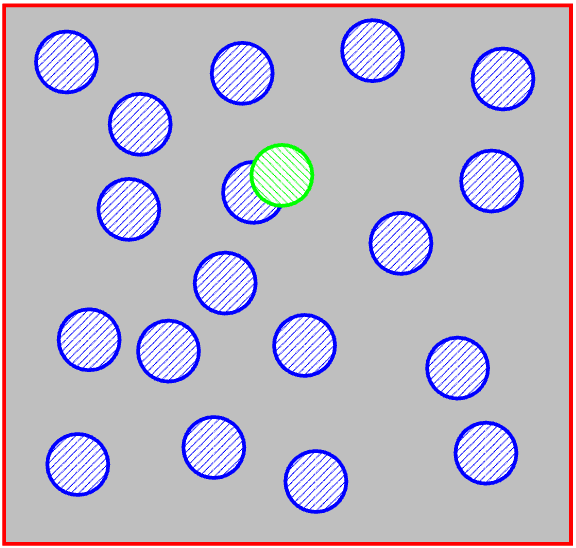
</div>


### 2. Static scheme
In every cycle, all disks are put at a
completely random position in the system. The radial distribution
function of this configuration is calculated and multiplied by the
Boltzmann factor of the system ($0$ when there is at least one overlap
and $1$ when there are no overlaps).
<div style="max-width:300px;margin-right: auto; margin-right: 0;">

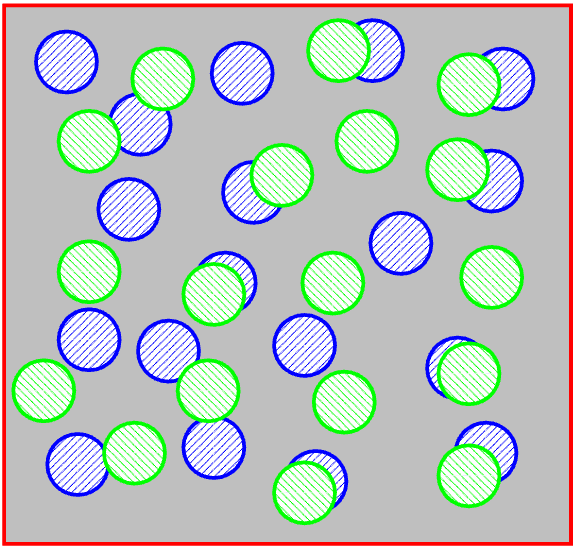
</div>

**Figures:** Eighteen hard disks in a box. The blue particles constitute the old system,
 the green particles the new system. The dynamic scheme performs a displacement trial move
 in one of the particles. The move is rejected when there is a overlap. The static scheme puts all
 particles at new random positions in the system. The move is accepted when there is no overlap.

## Periodic boundary conditions
In the Random Walk exercise from yesterday you already had a look at periodic boundary conditions. 
Periodic boundary conditions (PBCs) mimic an infinite system by tiling the simulation box with 
identical copies of itself. In a L by L box, particles leaving one side re-enter from the opposite 
side, ensuring continuity. Interactions are calculated using the minimum image convention, where 
each particle interacts with the closest image of other particles, considering the periodic replicas. 
This eliminates edge effects, making the finite system behave like an infinite one.

</div>

<div style="max-width: 1000px; margin: auto; font-size: 20px; line-height: 1.6;">

### Question 1:
Below is a Python code where the dynamic (```dynamicHardDisks```) Monte Carlo scheme is implemented. 
Your task is to complete the function ```checkOverlap``` and ```lowerTriangularDistMatrix``` for both cases: 
with and without periodic boundary conditions (PBC).

For hard disks:
- ***With PBC***: A particle can move outside the simulation box. This movement is treated as though it enters from 
the opposite side, effectively wrapping around the box. You must ensure that the particle does not overlap 
with any other particles or their periodic images after the move.
- ***Without PBC***: Particles are confined within the box. A move is only valid if the particle stays entirely 
within the box boundaries and does not overlap with any other particle.

The disk diameter is 1

</div>

In [7]:
@numba.njit
def lowerTriangularDistMatrix(positions: np.ndarray, numberOfParticles: int, boxSize: float, pbc: bool):
    """
    Computes the lower triangular portion of the pairwise distance matrix for a set of particles.
    
    Parameters:
        positions (np.ndarray): A 2D array of shape (numberOfParticles, dim), where dim is the dimensionality 
                                of the space. Each row represents the coordinates of a particle.
        numberOfParticles (int): The total number of particles in the system.
        boxSize (float): The size of the simulation box along each dimension (assumes cubic box).
        pbc (bool): Whether to apply periodic boundary conditions (PBC) to compute distances.
        
    Returns:
        np.ndarray: A 1D array containing the pairwise distances in the lower triangular part of the distance matrix
                    (excluding the diagonal). The length of the array is 0.5 * numberOfParticles * (numberOfParticles - 1).
    """

    # Initialize an array to store pairwise distances in the lower triangular format
    dist = np.zeros(int(0.5 * numberOfParticles * (numberOfParticles - 1)))

    # Counter to track the position in the `dist` array
    counter = 0

    # Iterate over all pairs of particles (i, j) with i < j
    for i in range(numberOfParticles - 1):
        for j in range(i + 1, numberOfParticles):
            # Compute the vector difference between positions of particles i and j
            dr = positions[i] - positions[j]
            
            # Apply periodic boundary conditions if `pbc` is True
            if pbc:
                #----------------add code below-------------------------#

                dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
                #-------------------------------------------------------#

            # Compute the Euclidean distance and store it in the `dist` array
            dist[counter] = np.sqrt(np.sum(dr**2))
            
            # Increment the counter
            counter += 1

    return dist


@numba.njit
def checkOverlap(newPosition: float, positions: np.ndarray, boxSize: float, particleIdx: int, pbc: bool):
    """
    Checks if a particle overlaps with others or is outside the box.

    Parameters:
        newPosition (float): The proposed position of the particle.
        positions (np.ndarray): The array of positions of all particles.
        boxSize (float): The size of the simulation box.
        particleIdx (int): Index of the particle being moved.
        pbc (bool): Whether periodic boundary conditions are applied.

    Returns:
        bool: True if there is an overlap, False otherwise.
    """
    # Check for boundary violations if PBC is off
    if pbc or (not pbc and (np.all(newPosition >= (0+0.5)) and np.all(newPosition <= (boxSize-0.5)))):
        dr = newPosition - positions
        # Apply periodic boundary conditions using 
        if pbc:
            #----------------add code below-------------------------#

            dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
            #-------------------------------------------------------#

        d = np.sqrt(np.sum(dr**2, axis=-1))
        d[particleIdx] = np.inf  # ignore the particle being moved

        # Check for overlaps
        return np.any(d < 1.0)
    else:
        return True

@numba.njit
def dynamicHardDisks(
    numberOfInitCycles: int,
    numberOfProdCycles: int,
    numberOfParticles: int,
    maxDisplacement: float,
    sampleFrequency: int,
    boxSize: float,
    rdfBins: int,
    pbc: bool,
):
    """
    Simulates a dynamic Monte Carlo hard disk system with optional periodic boundary conditions.
    
    Parameters:
        numberOfInitCycles (int): Number of initialization cycles.
        numberOfProdCycles (int): Number of production cycles.
        numberOfParticles (int): Number of particles in the system.
        maxDisplacement (float): Maximum displacement for random moves (not used in static mode).
        sampleFrequency (int): Frequency of sampling positions and RDF.
        boxSize (float): The size of the simulation box.
        rdfBins (int): Number of bins for the radial distribution function (RDF).
        pbc (bool): Whether to apply periodic boundary conditions (PBC).
        
    Returns:
        samplePositions (np.ndarray): Sampled positions of particles during production cycles.
        rdf (np.ndarray): The radial distribution function.
        sampleParticleIdx (np.ndarray): stores particle indices of MC move and acceptance of move
    """

    # Initialize lattice sites and positions array
    latticeSites = int(boxSize)  
    nLattice = latticeSites**2 
    positions = np.zeros((nLattice, 2)) 

    # Set up initial lattice positions
    count = 0
    for x in np.linspace(0, (1 - 1 / latticeSites) * boxSize, latticeSites):
        for y in np.linspace(0, (1 - 1 / latticeSites) * boxSize, latticeSites):
            positions[count] = np.array([x, y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]  # Randomly select initial particle positions

    # Prepare variables for sampling and RDF calculation
    numberOfSamples = numberOfProdCycles // sampleFrequency  
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2)) 
    sampleParticleIdx = np.zeros((numberOfSamples, 2))  
    sampleCounter = 0

    rdf = np.zeros(rdfBins)  

    numberOfAttemptedMoves = 0  
    numberOfAcceptedMoves = 0 

    # Main simulation loop
    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1
        displacement = (np.random.rand(2) - 0.5) * maxDisplacement  # Generate random displacement
        particleIdx = np.random.choice(numberOfParticles)  # Randomly select a particle to move
        sampleParticleIdx[sampleCounter, 0] = particleIdx
        newPosition = positions[particleIdx] + displacement  # Calculate new position

        # Check for overlaps and update position if valid
        overlap = checkOverlap(newPosition, positions, boxSize, particleIdx, pbc)
        if not overlap:
            positions[particleIdx] = newPosition  # Update particle position
            numberOfAcceptedMoves += 1

        # Perform sampling during production cycles
        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions 
            sampleParticleIdx[sampleCounter, 1] = not overlap  
            sampleCounter += 1

            # Compute pairwise distances and update RDF histogram
            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize, pbc)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    # Normalize the RDF
    areaNorm = np.pi * (edges[1:] ** 2 - edges[:-1] ** 2)  # Bin areas in radial distribution
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm  # Normalization factor
    rdf *= boxSize**2 / (r2 * sampleCounter)  # Normalize RDF by sample count and system size

    # Print acceptance ratio
    print(numberOfAcceptedMoves / numberOfAttemptedMoves)

    return samplePositions % boxSize, rdf, sampleParticleIdx



Run the static scheme for 1000 MC steps both with and without periodic boundary conditions.

In [8]:
boxSize = 20.0
periodic_boundary_conditions = True
x, rdf, pIdx = dynamicHardDisks(
    numberOfInitCycles=int(1e6),
    numberOfProdCycles=int(1e2),
    numberOfParticles=64,
    maxDisplacement=2.0,
    sampleFrequency=1,
    boxSize=boxSize,
    rdfBins=100,
    pbc=periodic_boundary_conditions,
)
hardDiskAnimation(x,boxSize,periodic_boundary_conditions,pIdx=pIdx)

0.7533926607339266


NameError: name 'hardDiskAnimation' is not defined

In [ ]:


# Function to compute periodic offsets
def get_periodic_offsets(boxSize):
    return [
        np.array([0, 0]),  # Original position
        np.array([boxSize, 0]),  # Right
        np.array([-boxSize, 0]),  # Left
        np.array([0, boxSize]),  # Up
        np.array([0, -boxSize]),  # Down
        np.array([boxSize, boxSize]),  # Top-right
        np.array([-boxSize, boxSize]),  # Top-left
        np.array([boxSize, -boxSize]),  # Bottom-right
        np.array([-boxSize, -boxSize]),  # Bottom-left
    ]


def hardDiskAnimation(x,boxSize, periodic_boundary_conditions, dynamic=True, pIdx=None):
    n_frames = np.shape(x)[0]
    n_particles = np.shape(x)[1]

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-0.25 * boxSize, boxSize * 1.25)
    ax.set_ylim(-0.25 * boxSize, boxSize * 1.25)
    ax.axhline(0)
    ax.axhline(boxSize)
    ax.axvline(0)
    ax.axvline(boxSize)
    ax.set_aspect("equal")

    # Pre-compute offsets for periodic images
    if periodic_boundary_conditions:
        offsets = get_periodic_offsets(boxSize)
    else:
        offsets = [np.array([0, 0])]
    n_offsets = len(offsets)
    # Pre-create all Circle objects
    circle_patches = []
    for _ in range(n_particles * n_offsets):  # Total number of circles
        circle = Circle((0, 0), 0.5, edgecolor="blue", fill=False)
        circle_patches.append(circle)
        ax.add_patch(circle)

    def update(frame):
        positions = x[frame] % boxSize  # Get positions for the current frame
        modifiedIdx = [int(pIdx[frame, 0]) * len(offsets) + i for i in range(len(offsets))]
        index = 0
        for position in positions:
            for offset in offsets:
                circle_patches[index].center = position + offset
                if dynamic:
                    if index in modifiedIdx:
                        circle_patches[index].set_edgecolor("red")
                        if pIdx[frame, 1]:
                            circle_patches[index].set_fill(True)
                    else:
                        circle_patches[index].set_edgecolor("blue")
                        circle_patches[index].set_fill(False)

                index += 1


    # Create the animation
    ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)
    # Prevent the static figure from displaying
    plt.close(fig)
    # Display the animation inline in Jupyter Notebook

    return HTML(ani.to_jshtml())

### Question 2:
Write a program to calculate $g\left(r\right)$. Once the radial distribution function is implemented, it can be used for both methods. 
Make sure that both methods give the same result when $N$ is small. 

### Question 2:
At which N does the second method starts to fail? Why?

### Question 3:
For which method will there be a larger correlation between
successive elements of the Markov chain? Explain.

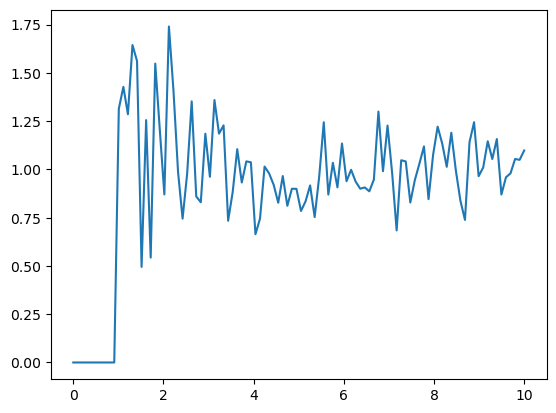

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0.0, 0.5 * boxSize, 100), rdf)

In [ ]:

@numba.njit
def staticHardDisks(
        numberOfInitCycles: int, 
        numberOfProdCycles: int, 
        numberOfParticles: int, 
        maxDisplacement: float, 
        sampleFrequency: int,
        boxSize: float,
        rdfBins: int, 
        pbc: bool,
    ):
    """
    Simulates a static Monte Carlo hard disk system with optional periodic boundary conditions.
    
    Parameters:
        numberOfInitCycles (int): Number of initialization cycles.
        numberOfProdCycles (int): Number of production cycles.
        numberOfParticles (int): Number of particles in the system.
        maxDisplacement (float): Maximum displacement for random moves (not used in static mode).
        sampleFrequency (int): Frequency of sampling positions and RDF.
        boxSize (float): The size of the simulation box.
        rdfBins (int): Number of bins for the radial distribution function (RDF).
        pbc (bool): Whether to apply periodic boundary conditions (PBC).
        
    Returns:
        samplePositions (np.ndarray): Sampled positions of particles during production cycles.
        rdf (np.ndarray): The radial distribution function.
    """
    latticeSites = int(boxSize)
    nLattice = latticeSites**2
    positions = np.zeros((nLattice, 2))

    # Initial lattice setup
    count = 0
    for x in np.linspace(0.5, (1 - 1 / latticeSites) * (boxSize-0.5), latticeSites):
        for y in np.linspace(0.5, (1 - 1 / latticeSites) * (boxSize-0.5), latticeSites):
            positions[count] = np.array([x, y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]

    # Sampling setup
    numberOfSamples = numberOfProdCycles // sampleFrequency
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2))
    sampleCounter = 0

    rdf = np.zeros(rdfBins)
    numberOfAttemptedMoves = 0
    numberOfAcceptedMoves = 0

    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1

        # Generate new positions
        if pbc:
            # With PBC, particles can be placed anywhere within the box
            newPositions = np.random.rand(numberOfParticles, 2) * boxSize
        else:
            # Without PBC, restrict placement to avoid overlapping the box boundaries
            minPos = 0.5  # Half the diameter of the disk
            maxPos = boxSize - 0.5
            newPositions = minPos + (np.random.rand(numberOfParticles, 2) * (maxPos - minPos))

        # Check for overlaps
        overlap = False
        for i in range(numberOfParticles - 1):
            for j in range(i + 1, numberOfParticles):
                dr = newPositions[i] - newPositions[j]
                if pbc:
                    # Apply PBC wrapping for distances
                    dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
                r2 = np.sum(dr**2)
                if r2 < 1.0:  # Overlap occurs if distance is less than the diameter
                    overlap = True
                    break
            if overlap:
                break

        if not overlap:
            positions = newPositions
            numberOfAcceptedMoves += 1

        # Sampling
        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions
            sampleCounter += 1

            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize, pbc)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    # Normalize RDF
    areaNorm = np.pi * (edges[1:]**2 - edges[:-1]**2)
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm
    rdf *= boxSize**2 / (r2 * sampleCounter)

    # Print acceptance ratio
    print(numberOfAcceptedMoves / numberOfAttemptedMoves)
    return samplePositions % boxSize, rdf


In [ ]:
boxSize = 20.0
x, rdf = staticHardDisks(
    numberOfInitCycles = int(1e6), 
    numberOfProdCycles = int(1e5), 
    numberOfParticles = 6, 
    maxDisplacement = 0.2, 
    sampleFrequency = 5000,
    boxSize = boxSize,
    rdfBins = 100,
    pbc= False
)

0.8814590909090909


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

n_frames = np.shape(x)[0]
n_particles = np.shape(x)[1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.25 * boxSize, boxSize * 1.25)
ax.set_ylim(-0.25 * boxSize, boxSize * 1.25)
ax.axhline(0)
ax.axhline(boxSize)
ax.axvline(0)
ax.axvline(boxSize)
ax.set_aspect("equal")
# Pre-compute offsets for periodic images
offsets = get_periodic_offsets(boxSize)
n_offsets = len(offsets)

# Pre-create all Circle objects
circle_patches = []
for _ in range(n_particles * n_offsets):  # Total number of circles
    circle = Circle((0, 0), 0.5, edgecolor="blue", fill=False)
    circle_patches.append(circle)
    ax.add_patch(circle)
# Create the animation
dynamic = False
ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)
# Prevent the static figure from displaying
plt.close(fig)
# Display the animation inline in Jupyter Notebook
from IPython.display import HTML

HTML(ani.to_jshtml())